In [1]:
from qadataset import QADataset
from config import dataset_config, model_config

MODEL_ID = "Salesforce/blip2-opt-2.7b"


train_dataset = QADataset(dataset_config, split="train[:100]")
val_dataset = QADataset(dataset_config, split="train[:20]")

/home/atomwalk12/Dropbox (Old)/notes/vision/project/BeyondVisionQA/model.py:128: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  self.metric = load_metric("bertscore")
/home/atomwalk12/anaconda3/envs/questllama/lib/python3.9/site-packages/datasets/load.py:756: FutureWarning: The repository for bertscore contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/bertscore/bertscore.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Map:   0%|          | 0/38575 [00:00<?, ? examples/s]

Map:   0%|          | 0/38575 [00:00<?, ? examples/s]

In [2]:
from torch.utils.data import Dataset, DataLoader
from trainer_blip2 import BLIP2ModelPLModule
from trainer_blip2 import BLIP2PLModule
import torch
from peft import LoraConfig, get_peft_model
from transformers import AutoProcessor, Blip2ForConditionalGeneration
from transformers import BitsAndBytesConfig, Blip2ForConditionalGeneration
import torch
from torch.utils.data import Dataset, DataLoader
from trainer_blip2 import BLIP2ModelPLModule
from trainer_blip2 import BLIP2PLModule
import torch
from peft import LoraConfig, get_peft_model
from transformers import AutoProcessor, Blip2ForConditionalGeneration
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

## Load model

# Three options for training, from the lowest precision training to the highest precision training:
# - QLora
# - Standard Lora
# - Full fine-tuning

def get_model():
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16
    )
    model = Blip2ForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        quantization_config=bnb_config,
    )


    lora_config = LoraConfig(
        r=8,
        lora_alpha=8,
        lora_dropout=0.1,
        target_modules="all-linear",
        init_lora_weights="gaussian",
    )

    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, lora_config)
    
model = get_model()
# processor = AutoProcessor.from_pretrained(MODEL_ID)
# model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", device_map="auto", load_in_8bit=True)
# # Let's define the LoraConfig
# config = LoraConfig(
#     r=16,
#     lora_alpha=32,
#     lora_dropout=0.05,
#     bias="none",
#     target_modules=["q_proj", "k_proj"]
# )

# model = get_peft_model(model, config)
# model.print_trainable_parameters()


# train_dataloader = DataLoader(train_dataset, collate_fn=BLIP2PLModule.train_textual_labels, batch_size=8, shuffle=True, num_workers=4)
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
# device = "cuda" if torch.cuda.is_available() else "cpu"

# model.to(device)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
import lightning as L
import torch
from config import dataset_config
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader
from config import metrics
from transformers import AutoProcessor
from dataset_configs.easy_vqa import translate

processor = AutoProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right" # during training, one always uses padding on the right

class BLIP2ModelPLModule(L.LightningModule):
    def __init__(self, hyperparameters, model, train_dataset, val_dataset):
        super().__init__()
        self.hyperparams = hyperparameters
        self.model = model
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

        self.batch_size = hyperparameters.get("batch_size")

    def training_step(self, batch, batch_idx):

        inputs, labels = batch

        outputs = self.model(**inputs,
                            labels=labels)
        loss = outputs.loss
        print(f"Epoch {self.current_epoch}, loss: {loss.item()}")

        self.log("train_loss", loss, batch_size=self.batch_size)

        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):

        inputs, answers = batch

        # auto-regressively generate token IDs

        
        generated_ids = self.model.generate(**inputs)
        # turn them back into text, chopping of the prompt
        # important: we don't skip special tokens here, because we want to see them in the output
        predictions = processor.batch_decode(generated_ids, skip_special_tokens=True)

        print(f"==================Dataset batch: {batch_idx}/{self.val_dataset.dataset_length // self.batch_size}==================")
        scores = []
        i = 0
        for pred, answer in zip(predictions, answers):
            print(f"Question: {self.val_dataset.dataset[batch_idx*self.batch_size+i]['question']}")
            print(f"Prediction: {pred}")
            print(f"Answer: {answer}")
            i += 1

        for metric in metrics:
            scores = metric.compute(predictions=predictions, references=answers, model=self)
            
        return scores

    def configure_optimizers(self):
       return torch.optim.Adam(self.parameters(), lr=5e-4)
        


class BLIP2PLModule(BLIP2ModelPLModule):
    
    def __init__(self, config, model, train_dataset, val_dataset):
        super().__init__(config, model, train_dataset, val_dataset)
    
    def train_numeric_labels(examples):
        images = []
        texts = []
        batch_labels = []
        for example in examples:
            image, ground_truth = example
            input, label = translate(ground_truth, training=True)
            
            images.append(image)
            texts.append(input)
            batch_labels.append({ 'label_ids': label['label_ids'], 'scores': torch.from_numpy(label['scores'])})

        # inputs = processor(images=images, text=texts, return_tensors="pt").to(device="cuda", dtype=torch.float16)
        inputs = processor(text=texts, images=images, padding=True, truncation=True, return_tensors="pt")
        
        result = []

        for label in batch_labels:
            scores = label['scores']
            result.append(scores)
        
        return inputs, torch.stack(result)


    
    def train_textual_labels(examples):
        images = []
        texts = []
        for example in examples:
            image, ground_truth = example
            input = translate(ground_truth, training=True)
            
            images.append(image)
            texts.append(input)    

        # inputs = processor(images=images, text=texts, return_tensors="pt").to(device="cuda", dtype=torch.float16)
        inputs = processor(text=texts, images=images, padding=True, return_tensors="pt")
        
        labels = inputs["input_ids"].clone()

        return inputs, labels

    def eval_numeric_labels(examples):
        images = []
        texts = []
        answers = []
        for example in examples:
            image, ground_truth = example
            input, output = translate(ground_truth, training=False)
            
            images.append(image)
            texts.append(input) 
            answers.append(output)

        inputs = processor(text=texts, images=images, padding=True, return_tensors="pt")

        return inputs, answers
    
    def eval_textual_labels(examples):
        images = []
        texts = []
        answers = []
        for example in examples:
            image, ground_truth = example
            input, output = translate(ground_truth, training=False)
            
            images.append(image)
            texts.append(input) 
            answers.append(output)

        inputs = processor(text=texts, images=images, padding=True, return_tensors="pt")

        return inputs, answers
    
    
    def train_dataloader(self):
        if model_config['classification']:
            return DataLoader(self.train_dataset, collate_fn=BLIP2PLModule.train_numeric_labels, batch_size=self.batch_size, shuffle=True, num_workers=4)
        else:
            return DataLoader(self.train_dataset, collate_fn=BLIP2PLModule.train_textual_labels, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        if model_config['classification']:
            return DataLoader(self.val_dataset, collate_fn=BLIP2PLModule.eval_numeric_labels, batch_size=self.batch_size, shuffle=False, num_workers=4)
        else:
            return DataLoader(self.val_dataset, collate_fn=BLIP2PLModule.eval_textual_labels, batch_size=self.batch_size, shuffle=False, num_workers=4)
        
    


hyperparameters = model_config['hyperparameters']
if model_config['target'] == 'blip2':
    module = BLIP2PLModule(hyperparameters, model, train_dataset, val_dataset)

In [4]:
import lightning as L

def train(module: L.LightningModule):
    hyperparams = model_config['hyperparameters']

    early_stop_callback = EarlyStopping(monitor="wup_measure", patience=3, verbose=False, mode="min")
    print(hyperparameters.values())
    trainer = L.Trainer(
            accelerator="gpu",
            devices=[0],
            max_epochs=100,
            accumulate_grad_batches=hyperparams.get("accumulate_grad_batches"),
            check_val_every_n_epoch=100,
            gradient_clip_val=hyperparams.get("gradient_clip_val"),
            precision="16-mixed",
            num_sanity_val_steps=0,
            default_root_dir=model_config['local_checkpoint_dir'],
            callbacks=[early_stop_callback],
    )

    trainer.fit(module)
    trainer.validate(module)

train(module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/atomwalk12/anaconda3/envs/questllama/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/genera

dict_values([20, 1.67, 1, 1.0, 8, 0.0005, 9, 1337, 1, './result', True, [0.9, 0.999], 0.05, 256])


/home/atomwalk12/anaconda3/envs/questllama/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, loss: 6.874007701873779
Epoch 0, loss: 5.443212032318115
Epoch 0, loss: 5.726525783538818
Epoch 0, loss: 5.582296848297119
Epoch 0, loss: 6.08299446105957
Epoch 0, loss: 5.11095666885376
Epoch 0, loss: 5.314000129699707
Epoch 0, loss: 5.9298505783081055
Epoch 0, loss: 5.438870906829834
Epoch 0, loss: 5.404477596282959
Epoch 0, loss: 5.6983466148376465
Epoch 0, loss: 4.121647357940674
Epoch 1, loss: 3.8298161029815674
Epoch 1, loss: 3.3930065631866455
Epoch 1, loss: 2.7952518463134766
Epoch 1, loss: 4.966162204742432
Epoch 1, loss: 3.537862539291382
Epoch 1, loss: 3.0506811141967773
Epoch 1, loss: 3.5888826847076416
Epoch 1, loss: 3.422295093536377
Epoch 1, loss: 2.253948926925659
Epoch 1, loss: 1.9641398191452026
Epoch 1, loss: 2.2987654209136963
Epoch 1, loss: 1.2863011360168457
Epoch 2, loss: 2.6830484867095947
Epoch 2, loss: 2.8315353393554688
Epoch 2, loss: 2.2140371799468994
Epoch 2, loss: 2.3414504528045654
Epoch 2, loss: 2.540097951889038
Epoch 2, loss: 2.00325274467468

Validation: |          | 0/? [00:00<?, ?it/s]

==================Dataset batch: 0/2==================
Question: what is the blue shape?
Prediction: : rectangle.
Answer: rectangle
Question: what color is the shape?
Prediction: 
Answer: blue
Question: does the image contain a rectangle?
Prediction: 
Answer: yes
Question: is there a triangle in the image?
Prediction: 
Answer: no
Question: is there a black shape?
Prediction: 
Answer: no
Question: does the image not contain a gray shape?
Prediction:  yes..
Answer: yes
Question: is there a red shape in the image?
Prediction:  no.
Answer: no
Question: does the image not contain a red shape?
Prediction:  yes..
Answer: yes
Question: is there not a blue shape?
Prediction: .:
Answer: no
accuracy: 0.0
f1score: 0.0
WUP Measure: 0.0 




Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


val_bertscore_f1: 0.49151268270280624 


==================Dataset batch: 1/2==================
Question: is there not a blue shape in the image?
Prediction:  no.
Answer: no
Question: is there not a yellow shape?
Prediction: .
Answer: yes
Question: is a teal shape present?
Prediction: .
Answer: no
Question: what color is the triangle?
Prediction: 
Answer: blue
Question: what color is the shape?
Prediction: 
Answer: blue
Question: is there not a rectangle in the image?
Prediction: 
Answer: yes
Question: is there a red shape?
Prediction: 
Answer: no
Question: is there a green shape in the image?
Prediction: 
Answer: no
Question: is there not a teal shape?
Prediction: 
Answer: yes
accuracy: 0.0
f1score: 0.0
WUP Measure: 0.0 


val_bertscore_f1: 0.29066164626015556 




==================Dataset batch: 2/2==================
Question: what shape is in the image?
Prediction:  triangle.: rectangle.
Answer: triangle
Question: what shape does the image contain?
Prediction:  triangle.:
Answer: triangle
accuracy: 0.0
f1score: 0.0
WUP Measure: 0.0 


val_bertscore_f1: 0.8563212454319 




`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

==================Dataset batch: 0/2==================
Question: what is the blue shape?
Prediction: : rectangle.
Answer: rectangle
Question: what color is the shape?
Prediction: 
Answer: blue
Question: does the image contain a rectangle?
Prediction: 
Answer: yes
Question: is there a triangle in the image?
Prediction: 
Answer: no
Question: is there a black shape?
Prediction: 
Answer: no
Question: does the image not contain a gray shape?
Prediction:  yes..
Answer: yes
Question: is there a red shape in the image?
Prediction:  no.
Answer: no
Question: does the image not contain a red shape?
Prediction:  yes..
Answer: yes
Question: is there not a blue shape?
Prediction: .:
Answer: no
accuracy: 0.0
f1score: 0.0
WUP Measure: 0.0 


val_bertscore_f1: 0.49151268270280624 




==================Dataset batch: 1/2==================
Question: is there not a blue shape in the image?
Prediction:  no.
Answer: no
Question: is there not a yellow shape?
Prediction: .
Answer: yes
Question: is a teal shape present?
Prediction: .
Answer: no
Question: what color is the triangle?
Prediction: 
Answer: blue
Question: what color is the shape?
Prediction: 
Answer: blue
Question: is there not a rectangle in the image?
Prediction: 
Answer: yes
Question: is there a red shape?
Prediction: 
Answer: no
Question: is there a green shape in the image?
Prediction: 
Answer: no
Question: is there not a teal shape?
Prediction: 
Answer: yes
accuracy: 0.0
f1score: 0.0
WUP Measure: 0.0 


val_bertscore_f1: 0.29066164626015556 




==================Dataset batch: 2/2==================
Question: what shape is in the image?
Prediction:  triangle.: rectangle.
Answer: triangle
Question: what shape does the image contain?
Prediction:  triangle.:
Answer: triangle
accuracy: 0.0
f1score: 0.0
WUP Measure: 0.0 


val_bertscore_f1: 0.8563212454319 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │            0.0            │
│          f1score          │            0.0            │
│     val_bertscore_f1      │    0.5461651682853699     │
│        wup_measure        │            0.0            │
└───────────────────────────┴───────────────────────────┘

What color is the shape?


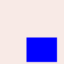

In [14]:
# load image
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
example = train_dataset[4]
image = example[0]

text_inputs = processor.tokenizer(
    example[1]["question"], padding=True, return_tensors="pt"
)
question = example[1]['question']
question = "What color is the shape?"
text = f"Question: {question} Answer:"
print(question)
image

In [15]:
inputs = processor(images=image, text=text, return_tensors="pt").to('cuda', torch.float16)
inputs

{'pixel_values': tensor([[[[1.8281, 1.8281, 1.8281,  ..., 1.8281, 1.8281, 1.8281],
          [1.8281, 1.8281, 1.8281,  ..., 1.8281, 1.8281, 1.8281],
          [1.8281, 1.8281, 1.8281,  ..., 1.8281, 1.8281, 1.8281],
          ...,
          [1.8281, 1.8281, 1.8281,  ..., 1.8281, 1.8281, 1.8281],
          [1.8281, 1.8281, 1.8281,  ..., 1.8281, 1.8281, 1.8281],
          [1.8281, 1.8281, 1.8281,  ..., 1.8281, 1.8281, 1.8281]],

         [[1.7598, 1.7598, 1.7598,  ..., 1.7598, 1.7598, 1.7598],
          [1.7598, 1.7598, 1.7598,  ..., 1.7598, 1.7598, 1.7598],
          [1.7598, 1.7598, 1.7598,  ..., 1.7598, 1.7598, 1.7598],
          ...,
          [1.7598, 1.7598, 1.7598,  ..., 1.7598, 1.7598, 1.7598],
          [1.7598, 1.7598, 1.7598,  ..., 1.7598, 1.7598, 1.7598],
          [1.7598, 1.7598, 1.7598,  ..., 1.7598, 1.7598, 1.7598]],

         [[1.7900, 1.7900, 1.7900,  ..., 1.7900, 1.7900, 1.7900],
          [1.7900, 1.7900, 1.7900,  ..., 1.7900, 1.7900, 1.7900],
          [1.7900, 1.7900

In [16]:
# prepare image for the model
import torch
inputs = processor(images=image, text=text, return_tensors="pt").to('cuda', torch.float32).to('cuda', torch.float16)
pixel_values = inputs.pixel_values

model.to('cuda')
# generated_ids = model.generate(pixel_values, max_length=25)
generated_ids = model.generate(**inputs)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

 blue.: is


: 